In [60]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [61]:
df = pd.read_csv("data/online_retail_II.csv", encoding='ISO-8859-1')

In [62]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [64]:
df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [65]:
df.rename(columns={'Customer ID':'CustomerId'},inplace=True)

In [66]:
df=df.drop(['CustomerId'],axis=1)

In [67]:
df.drop_duplicates(inplace=True)

In [68]:
df.shape

(536642, 7)

In [69]:
# 2. Handle missing values
df.dropna(subset=['Quantity', 'Price'], inplace=True)  # Drop rows where Quantity or Price is NaN
# 3. Remove negative values in Quantity and Price
df = df[(df['Quantity'] >= 0) & (df['Price'] >= 0)]
# 4. Create TotalSpend column
df['TotalSpend'] = df['Quantity'] * df['Price']
# 5. Optional: Convert Invoice to a categorical variable if it's not numeric
df['Invoice'] = df['Invoice'].astype('category').cat.codes

In [70]:
df.shape

(526053, 8)

In [71]:
# Sample a subset of the dataset if it's too large
df_sample = df.sample(frac=0.01, random_state=42)  # Take 10% of the data
# View first few rows of the cleaned dataset
print(df_sample.head())

        Invoice StockCode                     Description  Quantity  \
286763    11618     20727         LUNCH BAG  BLACK SKULL.        10   
524356    20205     20750        RED RETROSPOT MINI CASES         2   
410643    16263     23485   BOTANICAL GARDENS WALL CLOCK          4   
376753    15050     23407  SET OF 2 TRAYS HOME SWEET HOME         2   
239061     9740     20724     RED RETROSPOT CHARLOTTE BAG       100   

          InvoiceDate  Price         Country  TotalSpend  
286763    8/2/11 9:55   1.65          France        16.5  
524356   12/5/11 9:16   7.95        Portugal        15.9  
410643  10/21/11 8:24  20.80  United Kingdom        83.2  
376753  10/4/11 15:21   9.95  United Kingdom        19.9  
239061  6/24/11 10:03   0.72  United Kingdom        72.0  


Text(0, 0.5, 'TotalSpend')

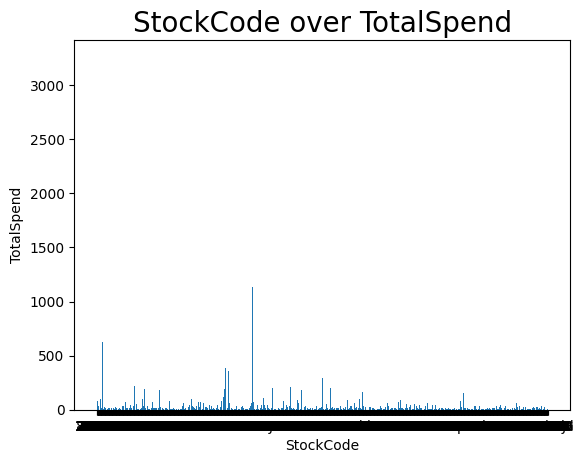

In [72]:
plt.bar(df_sample['StockCode'],df_sample['TotalSpend'])
plt.title('StockCode over TotalSpend',fontsize=20)
plt.xlabel('StockCode')
plt.ylabel('TotalSpend')

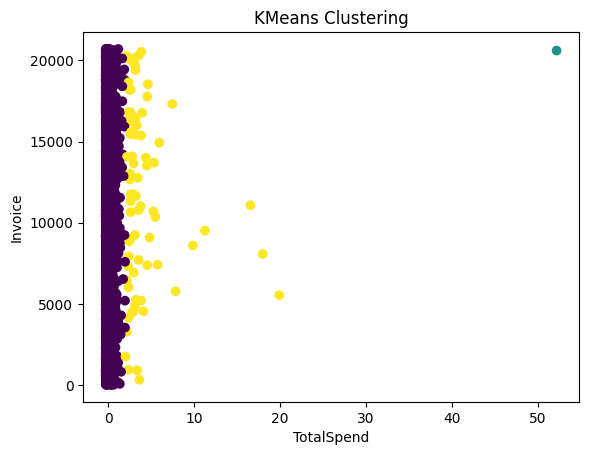

In [55]:
# Select features for clustering
X_numeric = df_sample[['TotalSpend']]
X = df_sample[['TotalSpend', 'Invoice']]
# Normalize the data (scaling the features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
# Update the scaled values in the DataFrame
df_sample[['TotalSpend']] = X_scaled
# Save the scaler for later use
joblib.dump(scaler, 'scaler.pkl')
# KMeans  Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # 3 clusters
kmeans.fit(X_scaled)
# Get the predicted cluster labels
df_sample['KMeansCluster'] = kmeans.labels_
# Save the trained KMeans model for later use
joblib.dump(kmeans, 'kmeans_model.pkl')
# Optionally, visualize the KMeans clustering results
plt.scatter(df_sample['TotalSpend'] ,df_sample['Invoice'], c=df_sample['KMeansCluster'], cmap='viridis')
plt.xlabel('TotalSpend')
plt.ylabel('Invoice')
plt.title('KMeans Clustering')
plt.show()

In [56]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print("The average silhouette score is :", silhouette_avg)

The average silhouette score is : 0.9296206397312735


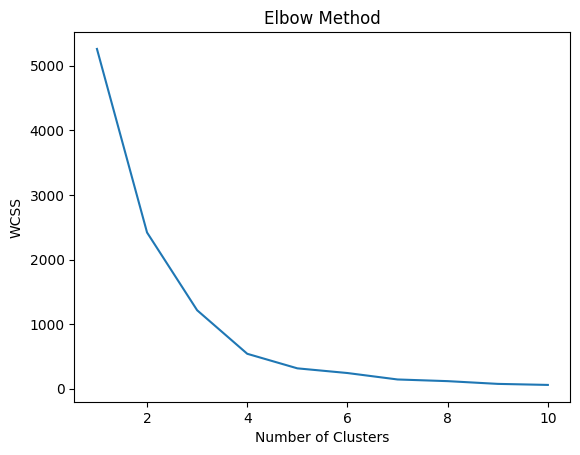

In [57]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Determine optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

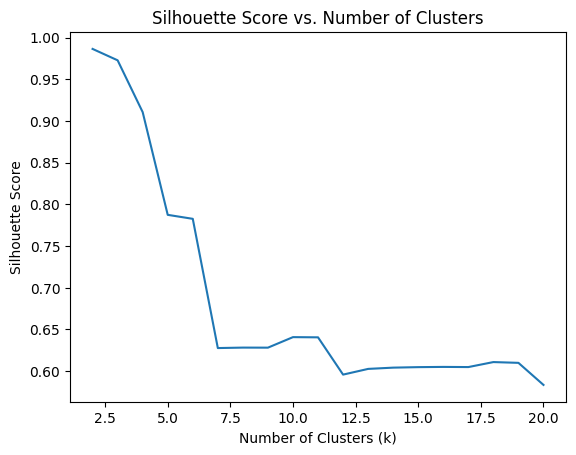

In [58]:
# Need to compute the kmeans with k from 1 to 20 and compute silhoutte score for them and then plot graph between them

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

silhouette_scores = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.plot(range(2, 21), silhouette_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.show()


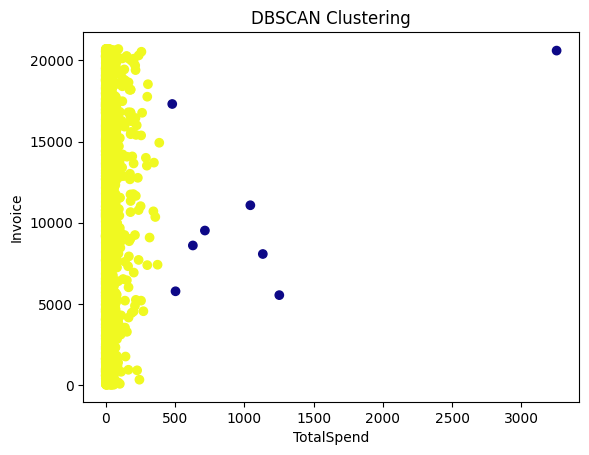

In [83]:
# DBSCAN Clustering
db=DBSCAN(eps=0.5,min_samples=5,metric='euclidean')  # eps is the maximum distance between two points to be considered neighbors
model=db.fit(X_scaled)
label=model.labels_
y_means = db.fit_predict(X_scaled)
# Add the DBSCAN labels to the DataFrame
df_sample['DBSCANCluster'] = y_means
# Save the trained DBSCAN model for later use
joblib.dump(dbscan, 'dbscan_model.pkl')
# visualize the DBSCAN results
plt.scatter(df_sample['TotalSpend'], df_sample['Invoice'], c=df_sample['DBSCANCluster'], cmap='plasma')
plt.xlabel('TotalSpend')
plt.ylabel('Invoice')
plt.title('DBSCAN Clustering')
plt.show()

In [82]:
# Calculate Silhouette Score for DBSCAN
from sklearn import metrics
silhouette_score_dbscan = metrics.silhouette_score(X_scaled, y_means)
print("Silhouette Score for DBSCAN: ", silhouette_score_dbscan)

Silhouette Score for DBSCAN:  0.9927761480456481


In [80]:
# Automatic code for selecting the best value of min samples and epslon based on siheoute score

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Range of epsilon and min_samples to explore
eps_range = np.arange(2, 15, 1)
min_samples_range = np.arange(2, 15, 1)

best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_range:
  for min_samples in min_samples_range:
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    model = db.fit(X_scaled)
    labels = model.labels_

    # Ignore cases where all points are noise
    if len(set(labels)) > 1:
      silhouette_score = metrics.silhouette_score(X_scaled, labels)
      if silhouette_score > best_score:
        best_score = silhouette_score
        best_eps = eps
        best_min_samples = min_samples

print("Best Silhouette Score:", best_score)
print("Best Epsilon:", best_eps)
print("Best Min Samples:", best_min_samples)


Best Silhouette Score: 0.9927761480456481
Best Epsilon: 6
Best Min Samples: 2
